In [1]:
import h5py
import matplotlib.pyplot as plt  
import torch
import IPython
from IPython.display import Audio
#import soundfile as sf
from scipy.io import wavfile
import numpy as np

In [80]:
%conda install librosa


Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - librosa

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


In [2]:
filename='/om2/user/msaddler/spatial_audio_pipeline/assets/GISE-51/processed_isolated_events.hdf5'

In [4]:
#extracting signals of my choosing, printing the names of the signals sampling rate is the same throughout

a=1203
b=9036
#9034,9037 speech; 7043 guitar

with h5py.File(filename, 'r') as f:
    print(f.keys())
    signal_1=(f['signal'])[a]
    signal_2=(f['signal'])[b]
    s_r1= (f['sr'])[0]
    s_r2= (f['sr'])[166]

    l_sig1=f['label'][a]
    l_sig2=f['label'][b]
    print(l_sig1, l_sig2)
    print(signal_1.dtype)
    print(signal_1)
   


<KeysViewHDF5 ['dur', 'fn_wav_fsd', 'fn_wav_gise', 'fxx', 'label', 'label_int', 'len', 'pxx', 'signal', 'split', 'split_int', 'sr']>
b'Harp' b'Human_speech'
float32
[-0.05929021 -0.07295691 -0.04457608 ... -0.007834   -0.0092168
  0.        ]


In [12]:
#finding min length of both and cropping 
min_len = min(len(signal_1), len(signal_2))
signal_1 = signal_1[:132000]
signal_2 = signal_2[:132000]


In [13]:
#creating overlapped signal 
overlap=signal_1+signal_2
print(len(overlap), len(signal_1),len(signal_2))


132000 132000 132000


In [14]:
#displaying overlap, must do saving on ipython
IPython.display.Audio(overlap,rate=s_r1,autoplay=True) 
#sf.write('overlapV2.wav', overlap, s_r1)  # eg on saving an array 

In [ ]:
IPython.display.Audio(signal_1,rate=s_r1,autoplay=True) 
#sf.write('signal_1V2.wav', signal_1, s_r1)

In [ ]:
IPython.display.Audio(signal_2,rate=s_r1,autoplay=True) 
#sf.write('signal_2V2.wav', signal_2, s_r2)

In [8]:
sampling_rate, signal_1V2_preds = wavfile.read("/om2/user/schen77/prj-slots/generated_figures/generated_audio/signal_1V2_preds.wav")
sampling_rate, signal_2V2_preds = wavfile.read("/om2/user/schen77/prj-slots/generated_figures/generated_audio/signal_2V2_preds.wav")

signal_1V2_preds=signal_1V2_preds.astype(np.float32)
signal_2V2_preds=signal_2V2_preds.astype(np.float32)

#single-channeling it
signal_1V2_preds=np.mean(signal_1V2_preds, axis=1)
signal_2V2_preds=np.mean(signal_2V2_preds, axis=1)

#normalize to -1 and 1 for #1 (harp)
max_abs = np.max(np.abs(signal_1V2_preds))
signal_1V2_preds = signal_1V2_preds / max_abs

#normalize to -1 and 1 for #2 (voice)
max_abs = np.max(np.abs(signal_2V2_preds))
signal_2V2_preds = signal_2V2_preds / max_abs

print(signal_1V2_preds.shape)
print(signal_2V2_preds)

(132000,)
[-0.16724654  0.07065251 -0.01376427 ... -0.0513337  -0.08725508
  0.1252823 ]


In [9]:
#creating overlapped signal reconstructed 
overlapV2_preds=signal_1V2_preds + signal_2V2_preds
print(len(overlapV2_preds), len(signal_1V2_preds),len(signal_2V2_preds))

132000 132000 132000


In [96]:
#making sure it sounds right (replace signal whatever with respsctive file)
IPython.display.Audio(overlapV2_preds,rate=s_r1,autoplay=True) 

In [22]:
import h5py
import matplotlib.pyplot as plt  
#import torch
import IPython
from IPython.display import Audio
import numpy as np
import tqdm




hf = h5py.File('/om2/user/schen77/testing_ugh.h5', 'w')#get rid of t
signal_list=np.vstack(signal_list)
arr1 = signal_list



hfdat = hf.create_group('data')
hfdat.create_dataset('signal_list', data=arr1) #delete dtype=dtype if doesn't work

hf.close()

print(hf)





<Closed HDF5 file>


In [15]:
signal_list=[]
signal_list.append(signal_1)
signal_list.append(signal_2)
signal_list.append(overlap)
signal_list.append(signal_1V2_preds)
signal_list.append(signal_1V2_preds)
signal_list.append(overlapV2_preds)
print(len(signal_list))

6


In [ ]:
#reading keys
with h5py.File(filename, 'r') as f:
    print(f.keys())
    e=len(f['signal'])
    print(e)

<KeysViewHDF5 ['dur', 'fn_wav_fsd', 'fn_wav_gise', 'fxx', 'label', 'label_int', 'len', 'pxx', 'signal', 'split', 'split_int', 'sr']>
16357


In [ ]:
#generate dataset
import numpy as np
from tqdm.notebook import tqdm

rng=np.random.default_rng()

#start off with 50 samples, end goal is 500k
num_samples=50

#empty lists to append info later to add to hdf5 file
signal_list=[]
label1_name=[]
label2_name=[]

sig_length = 1 # in seconds

with h5py.File(filename, 'r') as f:
    num_events = len(f['signal'])
    # find the sampling rate (assumed to be uniform across events)
    sr = f['sr'][0]

    for i in tqdm(num_samples):
        while True:
            #random assignment using rng.choice, numpy.random.Generator.choice
            indexes =rng.choice(num_events, 2, replace=False)
            ind1=indexes[0]
            ind2=indexes[1]

            #signal numpy array
            event1=f['signal'][ind1]
            event2=f['signal'][ind2]

            #making it the same length
            min_len = min(len(event1), len(event2))
            #print(min_len)
            if min_len > sig_length * sr:
                event1 = event1[:sig_length * sr]
                event2 = event2[:sig_length * sr]
                #generating overlapped audio file
                overlap=event1+event2
            
                signal_list.append(overlap)
                label1_name.append(f['label'][ind1])
                label2_name.append(f['label'][ind2])
                break
        
print(len(signal_list))


50


In [ ]:
hf.close()

In [ ]:
hf = h5py.File('testing.h5', 'w')
signal_list=np.vstack(signal_list)
arr1 = signal_list
arr2 = label1_name
arr3 = label2_name

# Create a variable-length datatype for the dataset if signals are different length
#dtype = h5py.special_dtype(vlen=np.dtype('float32'))

# convert numpy.bytes_ to Python strings
str_list2 = [n.decode('utf-8', 'ignore') for n in arr2]
str_list3 = [n.decode('utf-8', 'ignore') for n in arr3]

# use the encode method
asciiList = [n.encode('ascii', 'ignore') for n in str_list2]
asciiList2 = [n.encode('ascii', 'ignore') for n in str_list3]

hfdat = hf.create_group('data')
hfdat.create_dataset('signal_list', data=arr1) #delete dtype=dtype if doesn't work
hfdat.create_dataset('event1_label', (len(asciiList),1),'S10', asciiList)
hfdat.create_dataset('event2_label', (len(asciiList2),1),'S10', asciiList2)

hf.close()

print(hf)

<Closed HDF5 file>


In [ ]:
#random test stuff, ignore
with h5py.File('test.h5', 'r') as f:
    print(f.keys())
    print(f['data'].keys())

    dataset1=f['data']['seq1']
    print(dataset1[:])
    
    dataset2=f['data']['xxx']
    dataset3=f['data']['seq2']

<KeysViewHDF5 ['data']>
<KeysViewHDF5 ['seq1', 'seq2', 'xxx']>
[1 2 3 4 5]


In [120]:
a=1
#2=voice aka #2, #1=music #0=mixed
with h5py.File('/om2/user/schen77/testingugh.h5', 'r') as g:

    print(g.keys())
    print(g['data'].keys())


    sample=g['data']['signal_list'][a]
    #label1=g['data']['event1_label'][a]
    #label2=g['data']['event2_label'][a]
    print(len(g['data']['signal_list'][a]))

#print(label1, label2)
IPython.display.Audio(sample,rate=50000,autoplay=True) 

<KeysViewHDF5 ['data']>
<KeysViewHDF5 ['signal_list']>
132000


In [ ]:
filename='/om2/user/msaddler/spatial_audio_pipeline/assets/GISE-51/processed_isolated_events.hdf5'

In [ ]:
with h5py.File(filename, 'r') as f:
    print(f.keys())
    signal_1=(f['signal'])[0]
    signal_2=(f['signal'])[166]
    s_r1= (f['sr'])[0]
    s_r2= (f['sr'])[166]

<KeysViewHDF5 ['dur', 'fn_wav_fsd', 'fn_wav_gise', 'fxx', 'label', 'label_int', 'len', 'pxx', 'signal', 'split', 'split_int', 'sr']>


In [ ]:
with h5py.File(filename, 'r') as f:
    b=f['dur'][:]
    print(b)
    print(min(b))
    print(max(b))

list=[]
for i in range(len(b)):
    list.append(b[i])

print(list)

print(list.index(140.1941))
print(list.index(0.02582))

[16.55522  6.72274  9.17226 ...  0.92242  0.2584   4.02122]
0.02582
140.1941
[16.55522, 6.72274, 9.17226, 6.30422, 3.1572, 4.1558, 1.91512, 2.43138, 6.5288, 13.99724, 2.83858, 1.91344, 3.50874, 5.8619, 4.63862, 1.72584, 4.02614, 4.55254, 4.47168, 2.418, 4.09522, 0.7159, 3.75108, 1.60004, 4.73484, 3.04196, 3.05032, 3.24266, 2.24872, 1.68386, 2.26626, 2.1092, 1.70586, 4.41862, 2.35194, 5.57368, 2.94702, 1.67088, 4.20292, 2.32752, 2.43986, 3.52046, 1.62176, 12.98138, 0.57634, 5.92574, 1.38608, 0.7019, 1.36766, 0.1983, 0.35928, 0.88688, 1.23292, 0.20904, 0.41418, 1.35904, 1.23652, 0.50648, 0.25142, 0.3354, 0.1442, 0.77538, 1.90372, 1.79946, 0.2131, 0.29426, 0.63972, 6.7924, 1.30382, 1.0419, 0.7399, 3.27382, 0.69498, 1.39766, 8.56, 0.594, 0.72838, 1.0211, 4.64534, 0.11818, 0.3189, 1.646, 0.41518, 0.7537, 0.73498, 0.42834, 0.33574, 1.9011, 2.4293, 0.28046, 0.37294, 0.42432, 0.2825, 0.33388, 0.42162, 0.44618, 0.58448, 0.64042, 0.72918, 0.4305, 0.26548, 0.18036, 0.41868, 2.1928, 5.55054, 3.922

In [ ]:
#was just bored thought this was interesting 

number= 700
#3999=0.02582/s | crumpling and crinkling and crushing
#8820=140.1941/s | human speech | but music in background+clapping+ crinkling as well

with h5py.File(filename, 'r') as f: 
    signal=f['signal'][number]
    name=f['label'][number]

IPython.display.Audio(signal,rate=s_r1,autoplay=True) 



NameError: name 's_r1' is not defined

10366
3.7890351983860113 6.24884 1.75516


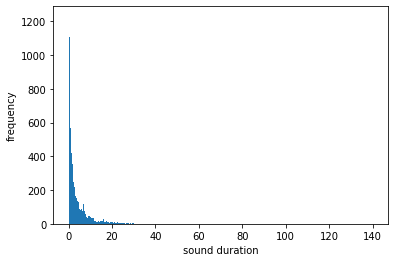

In [ ]:
import statistics 
import numpy as np

print(np.sum(np.array(list) > 1))
mean= sum(list) / len(list)
mode=statistics.mode(list)
median=statistics.median(list)

print(mean, mode, median)

import matplotlib.pyplot as plt
plt.hist(list,1000)
plt.xlabel('sound duration')
plt.ylabel('frequency')
plt.show()


In [ ]:
!conda install librosa

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - librosa

Current channels:

  - https://repo.anaconda.com/pkgs/main/linux-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/linux-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [ ]:
filename = '/om2/user/msaddler/spatial_audio_pipeline/assets/GISE-51/processed_isolated_events.hdf5'


In [ ]:
with h5py.File(filename, 'r') as f: 
    print(f['label'][:])

[b'Applause' b'Applause' b'Applause' ... b'Zipper_(clothing)'
 b'Zipper_(clothing)' b'Zipper_(clothing)']
